In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


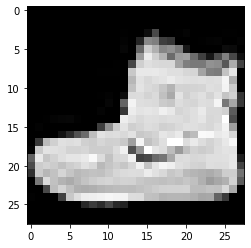

In [4]:
plt.figure()
plt.imshow(train_images[0], cmap='gray')
plt.show()

In [5]:
train_images = (train_images - 127.5) / 127.5

In [6]:
# latent dimension of the random noise
LATENT_DIM = 100
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 1

In [17]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name="generator")

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(7 * 7 * 256, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((7, 7, 256)))

    # upsample to 14x14: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 28x28: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (5, 5), padding="same", activation="tanh"))

    # return the generator model
    return model


In [18]:
# build the generator model
generator = build_generator()


In [19]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1266944   
                                                                 
 batch_normalization_5 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 128)      819328    
 ranspose)                                                       
                                                                 
 batch_normalization_6 (Batc  (None, 14, 14, 128)      51

In [20]:
def build_discriminator(width, height, depth, alpha=0.2):
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)
       # first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))
    
    # second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

In [21]:
discriminator = build_discriminator(28, 28, 1)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_8 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_9 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 128)       

In [22]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        # G wants D to think the fake images are real (label as 1)
        misleading_labels = tf.ones((batch_size, 1)) 

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [23]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during training
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        # generated_images = self.model.generator(random_latent_vectors)
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')


In [24]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

In [25]:
LR = 0.0002 # learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)


In [26]:
NUM_EPOCHS = 50 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

Output hidden; open in https://colab.research.google.com to view.